## SRCNN

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(128, 128, 3), name='img')

x = layers.Conv2D(
    filters=64,             # Number of convolutional layer neurons (convolutional kernels)
    kernel_size=9,          # size
    padding='same',         # padding（vaild or same）
    activation=tf.nn.relu   # active function
)(inputs)

x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation=tf.nn.relu
)(x)

outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,          
    padding='same'          # no active function 
)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='SRCNN_model')# Create a model
  
model.summary() # see model sunmmary
model = tf.keras.models.load_model('SRCNN.h5')


Model: "SRCNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      15616     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 3)       2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


# SRGAN

In [15]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [16]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

DIV2K dataset

In [63]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')

In [64]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, use the weight folder which containing the weights of the pre-trained models.

### Generator pre-training

In [ ]:
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=1000000, 
                  evaluate_every=1000, 
                  save_best_only=False)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

### Generator fine-tuning (GAN)

In [ ]:
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds, steps=200000)

80142336/80134624 [==============================] - 11s 0us/step
50/200000, perceptual loss = 0.0825, discriminator loss = 1.8575
100/200000, perceptual loss = 0.0757, discriminator loss = 1.2892


In [ ]:
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

## Demo

In [93]:
from model import resolve_single
from utils import load_image
pre_generator = generator()
gan_generator = generator()


pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

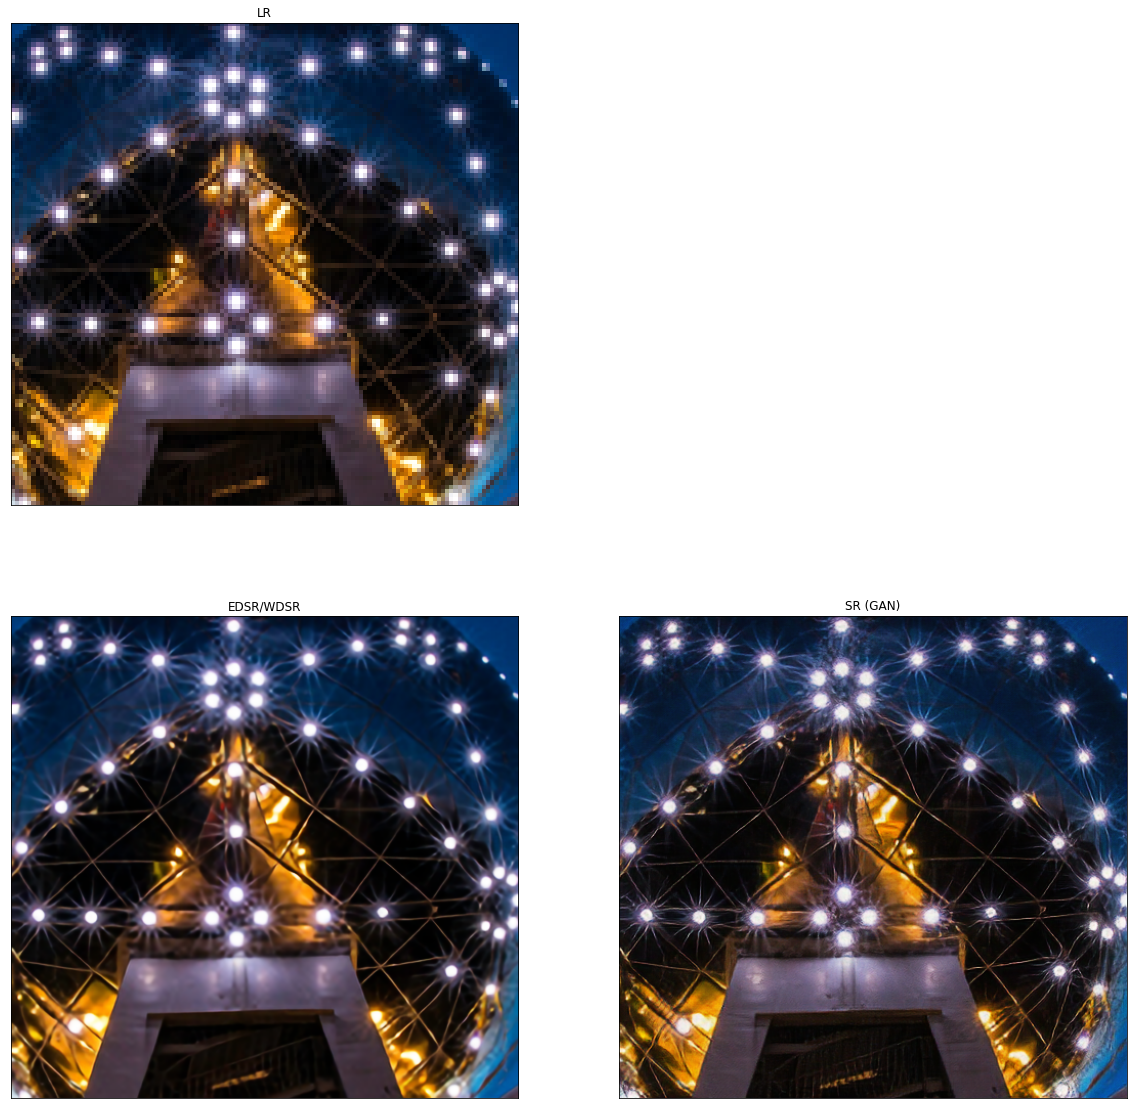

In [120]:
lr = load_image('demo/0851x4-crop.png')
pre_sr = resolve_single(pre_generator, lr)
gan_sr = resolve_single(gan_generator, lr)
   
plt.figure(figsize=(20, 20))
ishape = 128
#load enlarge pictures
img = cv.imread('demo/0829x4-crop.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img1 = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)# (36,36,3)->(128,128,3)
img1 = np.reshape(img1,(1,ishape,ishape,3)) / 255.

# Processing image super-resolution
img_SR = model.predict(img1)

images = [lr, pre_sr, gan_sr]
titles = ['LR', 'EDSR/WDSR', 'SR (GAN)']
positions = [1,3, 4]
plt.imshow(gan_sr)
for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
    plt.subplot(2, 2, pos)
    plt.imshow(img)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
plt.savefig('demo2.png')

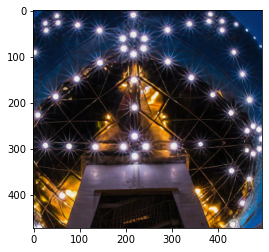

In [114]:
plt.imshow(gan_sr)
plt.savefig('demo2.png')

   

In [115]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import skimage.io as io

image1 = io.imread('demo2.png')[...,0]
image2 = io.imread('demo1.png')[...,0]

psnr_val = peak_signal_noise_ratio(image1, image2)
ssim_val = structural_similarity(image1,image2,win_size=11,gaussian_weights=True,multichannel=True,data_range=1.0,K1=0.01,K2=0.03,sigma=1.5)
print("psnr_val",psnr_val)
print("ssim_val",ssim_val)


psnr_val 19.692545148797976
ssim_val 0.8620119471333344


In [42]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import skimage.io as io


image1 = io.imread('demo0.png')[...,0]
image2 = io.imread('demo2.png')[...,0]

psnr_val = peak_signal_noise_ratio(image1, image2)
ssim_val = structural_similarity(image1,image2,win_size=11,gaussian_weights=True,multichannel=True,data_range=1.0,K1=0.01,K2=0.03,sigma=1.5)
print("psnr_val",psnr_val)
print("ssim_val",ssim_val)


psnr_val 12.88756741059338
ssim_val 0.5613082561383578


In [31]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import skimage.io as io


image1 = io.imread('demo0.png')[...,0]
image2 = io.imread('SRCNN0004.png')[...,0]

psnr_val = peak_signal_noise_ratio(image1, image2)
ssim_val = structural_similarity(image1,image2,win_size=11,gaussian_weights=True,multichannel=True,data_range=1.0,K1=0.01,K2=0.03,sigma=1.5)
print("psnr_val",psnr_val)
print("ssim_val",ssim_val)


psnr_val 16.85428929995579
ssim_val 0.6574650236136703


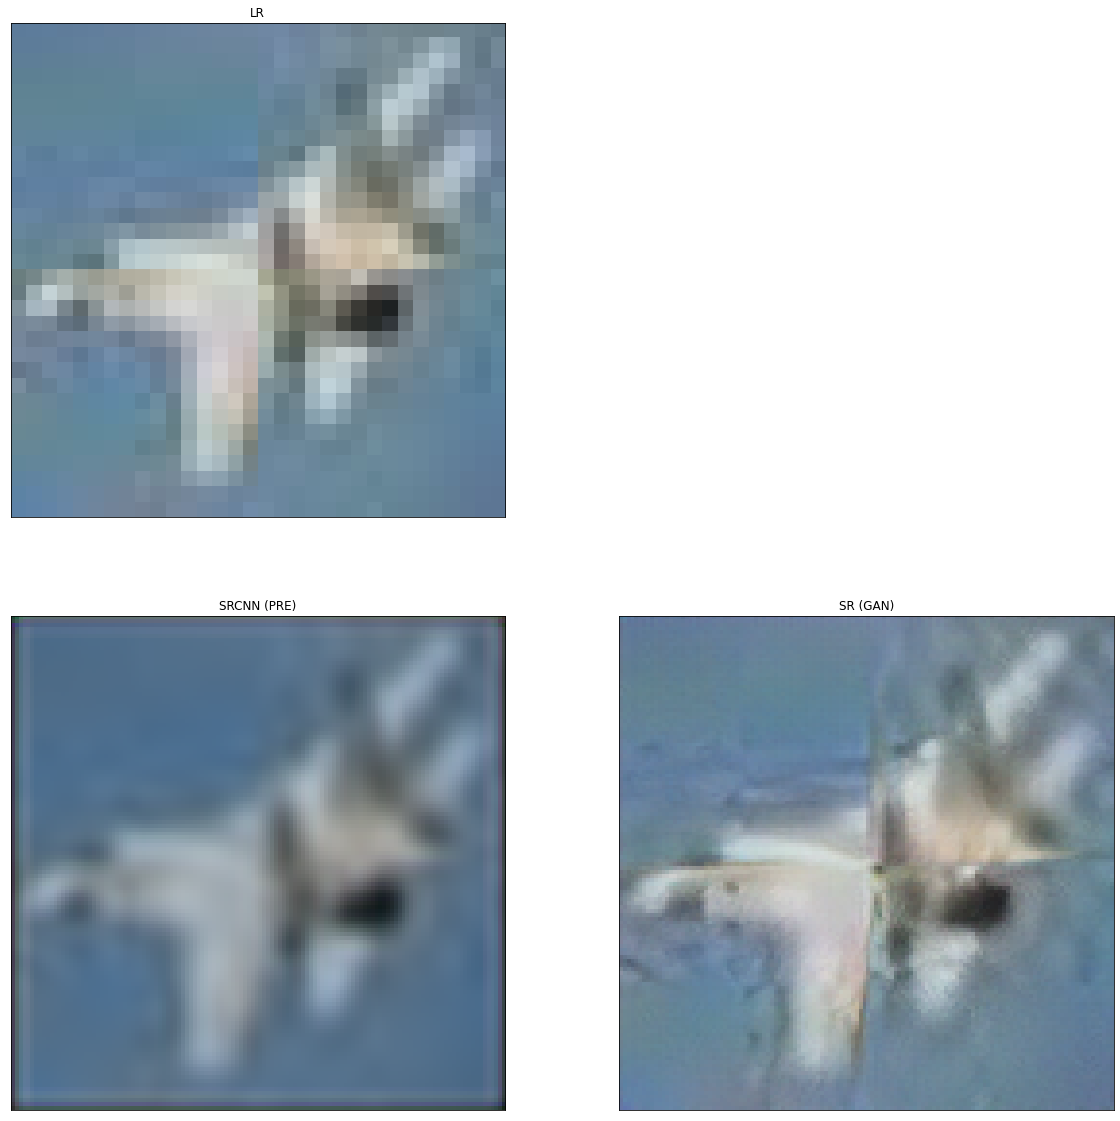

In [16]:
resolve_and_plot('0001.jpg')
plt.savefig("demo3.png")

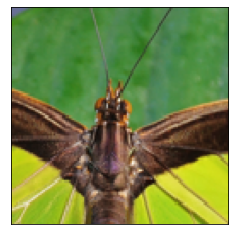

In [8]:
import cv2 as cv
from matplotlib import pyplot as plt

ishape = 128

#load enlarge pictures
img = cv.imread('demo/0829x4-crop.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img1 = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)# (36,36,3)->(128,128,3)
plt.imshow(img1)

plt.xticks([]), plt.yticks([])
plt.savefig("before0004.png") #store picture before super-resolution
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


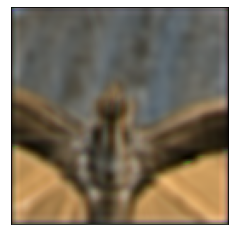

In [10]:
import numpy as np

img1 = np.reshape(img1,(1,ishape,ishape,3)) / 255.

# Processing image super-resolution
img_SR = model.predict(img1)

plt.imshow(img_SR[0])
[]
plt.xticks([]), plt.yticks([])
plt.savefig("SRCNN0004.png") # store picture after super-resolution
plt.show()